In [79]:
import sparknlp
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = 'pyspark-shell'

In [80]:
from pyspark.sql import SparkSession, functions as F 
from pyspark.sql.types import *


In [81]:
#from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Covid-SentimentAnalysis").getOrCreate()
df = spark.read.option("header" , "true" ).option("inferSchema", "true" ).csv('/antarjita/*.CSV')

In [82]:
df.show(10,False)

+---------------------------------------------------+-------------------+--------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+---------------+--------------------+---------------+-------------+------------+--------------------+--------+----+
|status_id                                          |user_id            |created_at          |screen_name |text                                                                                                                                                                                                                                               |source   |reply_to_status_id|reply_to_user_id|reply

In [83]:
df.printSchema()

root
 |-- status_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- reply_to_status_id: string (nullable = true)
 |-- reply_to_user_id: string (nullable = true)
 |-- reply_to_screen_name: string (nullable = true)
 |-- is_quote: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- favourites_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- place_full_name: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- account_lang: string (nullable = true)
 |-- account_created_at: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- lang: string (nullable = true)



In [84]:
type(df)
df.count()

18597061

In [85]:
drop_list = ['status_id','user_id','screen_name','source','reply_to_status_id','reply_to_user_id','is_retweet','place_full_name','place_type','reply_to_screen_name','is_quote','followers_count','friends_count','account_lang','account_created_at','verified']

df=df.select([column for column in df.columns if column not in drop_list])

In [86]:
df.show(10,False)

+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+------------+----+
|created_at          |text                                                                                                                                                                                                                                               |favourites_count|retweet_count|country_code|lang|
+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+------------+----+
|2020-03-29T00:00:00Z|Ante cualquier enfermedad resp

In [87]:
type(df)

pyspark.sql.dataframe.DataFrame

In [88]:
df=df[(df.country_code == "IN") & (df.lang == "en")]

In [89]:
df.show(10,False)

+--------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+------------+----+
|created_at          |text                                                                                                                                                                                                                                                                                              |favourites_count|retweet_count|country_code|lang|
+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [90]:
type(df)

pyspark.sql.dataframe.DataFrame

In [91]:
df=df.drop('country_code','lang')

In [92]:
df.show(5,False)

+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+
|created_at          |text                                                                                                                                                                                                                                                                     |favourites_count|retweet_count|
+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+
|2020-03-29T00:04:06Z|"""#Covid19: #Soci

In [93]:
type(df)

pyspark.sql.dataframe.DataFrame

In [94]:
#find NAN values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----------+----+----------------+-------------+
|created_at|text|favourites_count|retweet_count|
+----------+----+----------------+-------------+
|         0|   0|               0|            0|
+----------+----+----------------+-------------+



In [95]:
split_col = F.split(df['created_at'],'T')
df = df.withColumn('Date', split_col.getItem(0))
df = df.withColumn('Time', split_col.getItem(1))
df=df.drop('created_at')
df.show()
#df.select("created_at") =df.select("created_at").apply(lambda i:(int(i.split("T")[1].split(":"))))


+--------------------+----------------+-------------+------------------+---------+
|                text|favourites_count|retweet_count|              Date|     Time|
+--------------------+----------------+-------------+------------------+---------+
|"""#Covid19: #Soc...|           10374|            0|        2020-03-29|00:04:06Z|
|@ayush4bharat Ver...|             236|            0|        2020-03-29|00:17:57Z|
|I have made a sma...|           48715|            1|        2020-03-29|00:35:14Z|
|#COVID19: Madurai...|             339|            0|        2020-03-29|00:41:09Z|
|#Coronavirus | Po...|             339|            0|        2020-03-29|00:42:40Z|
|Because killers a...|            3798|            0|        2020-03-29|00:53:50Z|
|"""Coronavirus Tw...|           65863|            0|        2020-03-29|01:04:16Z|
|For every article...|           32080|            0|        2020-03-29|01:24:35Z|
|We need to unders...|           32080|            0|        2020-03-29|01:27:17Z|
|Hav

In [96]:
data=df.toPandas()

In [97]:
df= df.withColumn("text",F.regexp_replace(df["text"], r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)"," "))

In [98]:
df.show(10,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+----------+---------+
|text                                                                                                                                                                                                                                                                               |favourites_count|retweet_count|Date      |Time     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------+----------+---------+
|    Covid

# Insights from the dataset

1) Top five retweets replied back

In [99]:
retweet=df['retweet_count','text'].sort(col('retweet_count').desc()).rdd.flatMap(lambda x: x).collect()

#retweet.show(5,False)
for i in range(5):
    retweet[2*i+1]=retweet[2*i+1].lower()
    print(i,']', retweet[2*i+1],'\n')

0 ] dear   ji  matching steps with your relentless efforts to save our people from  coronavirus we have made this prayer to appreciate the spirit of  coronawarriors  amp  make the cry of  humanity reach out to the almighty   sambhaallena       

1 ] ten  10  new ventilators installed at rims on 07 04 2020   ready to overcome  covid 19   thanks to dr shanta singh  director rims and other officials for your tireless efforts    

2 ] big   rajasthan govt is going all out to take over 84 private hospitals  a circular has been sent to all hospitals to give over the control within two hours of when the order will be released  they have been informed today  covid 19india  coronavirus   

3 ] 12 staffers of jaslok hospital including nurses  technicians  helpers and a cook turn positive for covid 19  swabs of 300 staffers and patients taken  hospital declared a containment zone  covid 19 

4 ] i love my india      stayhomestaysafe   



2)top five most favourited tweets

In [68]:
favourite_tweets = df['favourites_count','text'].sort(col('favourites_count').desc()).rdd.flatMap(lambda x: x).collect()
for i in range(5):
    favourite_tweets[2*i+1]=favourite_tweets[2*i+1].lower()
    print(i,']', favourite_tweets[2*i+1],'\n')

0 ] stop the stigma   covid 19   a south mumbai coronavirus survivor speaks to me about the harassment he faced  i pray this doesn t repeat  let s show some empathy  love and compassion  he battled and survived this and is back to normal      

1 ] a south mumbai resident  a  coronavirus survivor speaks to me  harassed  named  shamed  affluent  educated neighbourhood misbehaves  are we  covidiots to stigmatise this  society needs to show empathy  get real  accept and cooperate  interview will be on air soon     

2 ] news reports coming in    taken into icu  condition worsens  coronavirus 

3 ]   ji is suffering from multiple ailments including hypertension  chronic kidney disease and hypertrophy of prostate  in the wake of the apex court s directive on  covid 19 an ailing and ageing   chief must be given parole   releaselaluprasadyadav 

4 ] a tiger tests positive for  covid19   



3)What hashtags has been viral/most used in covid tweets?

In [100]:
import re
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
data['hash']=data['text'].apply(lambda x:find_hash(x))

In [101]:
hastags=list(data[(data['hash'].notnull())&(data['hash']!="")]['hash'])
hastags = [each_string.lower() for each_string in hastags]
hash_df=dict(Counter(hastags))
top_hash_df=pd.DataFrame(list(hash_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_hash_df.head(10)

word  count
1                  covid19   1019
5              coronavirus    974
7                 covid_19    360
1479      stayhomestaysafe    207
29     coronaviruspandemic    117
2      coronavirusoutbreak    109
47     coronavirus covid19     30
260    covid19 coronavirus     22
57        lockdown covid19     20
251   coronavirus lockdown     15

In [103]:
import plotly.graph_objects as go
fig = go.Figure(go.Bar(
    x=top_hash_df['word'],y=top_hash_df['count'],
    marker={'color': top_hash_df['count'], 
    'colorscale': 'greens'},  
    text=top_hash_df['count'],
    textposition = "outside",
))
fig.update_layout(title_text='Top Trended Hashtags',xaxis_title="Hashtags ",
                  yaxis_title="Number of Tags ",template="plotly_dark",height=500,title_x=0.5)
fig.show()

# NLP 

In [28]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import seaborn as sns

In [29]:
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative

In [30]:
sentiment = udf(apply_blob, DoubleType())

In [31]:
result=df.withColumn("sentiment", sentiment(df['text']))
result.show()

+--------------------+----------------+-------------+------------------+---------+---------+
|                text|favourites_count|retweet_count|              Date|     Time|sentiment|
+--------------------+----------------+-------------+------------------+---------+---------+
|    Covid19   Soc...|           10374|            0|        2020-03-29|00:04:06Z|      0.0|
|  Very unfortunat...|             236|            0|        2020-03-29|00:17:57Z|      2.0|
|I have made a sma...|           48715|            1|        2020-03-29|00:35:14Z|      2.0|
| COVID19  Madurai...|             339|            0|        2020-03-29|00:41:09Z|      0.0|
| Coronavirus   Po...|             339|            0|        2020-03-29|00:42:40Z|      0.0|
|Because killers a...|            3798|            0|        2020-03-29|00:53:50Z|      1.0|
|   Coronavirus Tw...|           65863|            0|        2020-03-29|01:04:16Z|      0.0|
|For every article...|           32080|            0|        2020-03-2

distribution of the tweets

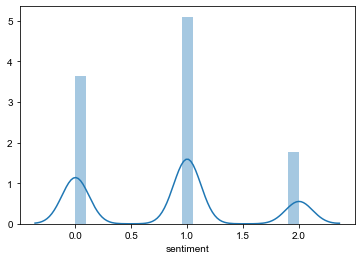

In [32]:
df_res_pandas = result.toPandas()
sns.distplot(df_res_pandas['sentiment'])
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [33]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

In [34]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

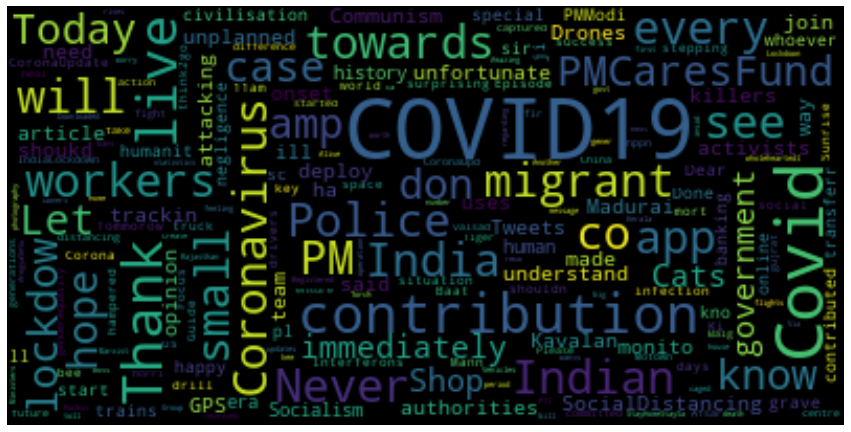

In [35]:
def show_wordcloud(data , title = None):
    wordcloud = WordCloud(background_color='black',stopwords=stopwords,max_words=200,max_font_size=40).generate(str(data))
  
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title(title, size = 25)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(df_res_pandas['text'])

In [36]:
df_res_pandas['sentiment'] = ' '
df_res_pandas['polarity'] = None
for i,tweets in enumerate(df_res_pandas.text) :
    blob = TextBlob(tweets)
    df_res_pandas['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        df_res_pandas['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        df_res_pandas['sentiment'][i] = 'negative'
    else :
        df_res_pandas['sentiment'][i] = 'neutral'
df_res_pandas.head(10)

text favourites_count  \
0      Covid19   SocialDistancing the Indian way ...            10374   
1    Very unfortunate to see this unplanned  ill ...              236   
2  I have made a small contribution towards my co...            48715   
3   COVID19  Madurai Kavalan app uses GPS trackin...              339   
4   Coronavirus   Police deploy  Drones to monito...              339   
5  Because killers are having a team of activists...             3798   
6     Coronavirus Tweets from Indian authorities ...            65863   
7  For every article and every opinion attacking ...            32080   
8  We need to understand most of India has a join...            32080   
9  Having said all this migrant workers shoukd ha...            32080   

  retweet_count        Date       Time sentiment  polarity  
0             0  2020-03-29  00:04:06Z   neutral         0  
1             0  2020-03-29  00:17:57Z  negative    -0.575  
2             1  2020-03-29  00:35:14Z  negative     -0.25  
3             0  2020-03-29  00:41:09Z   neutral         0  
4             0  2020-03-29  00:42:40Z   neutral         0  
5             0  2020-03-29  00:53:50Z  positive   0.09375  
6             0  2020-03-29  01:04:16Z   neutral         0  
7             0  2020-03-29  01:24:35Z  negative     -0.25  
8             0  2020-03-29  01:27:17Z  positive  0.142424  
9             1  2020-03-29  01:32:48Z  positive     0.275

positive    4129
neutral     2945
negative    1424
Name: sentiment, dtype: int64


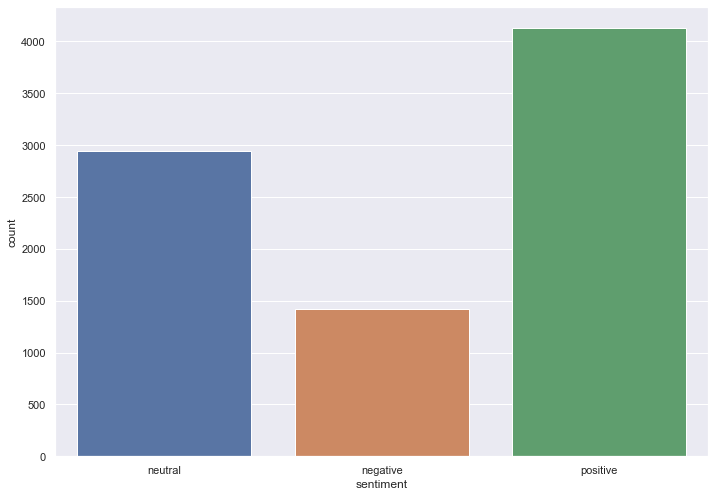

In [37]:
print(df_res_pandas.sentiment.value_counts())
sns.countplot(x='sentiment', data = df_res_pandas);

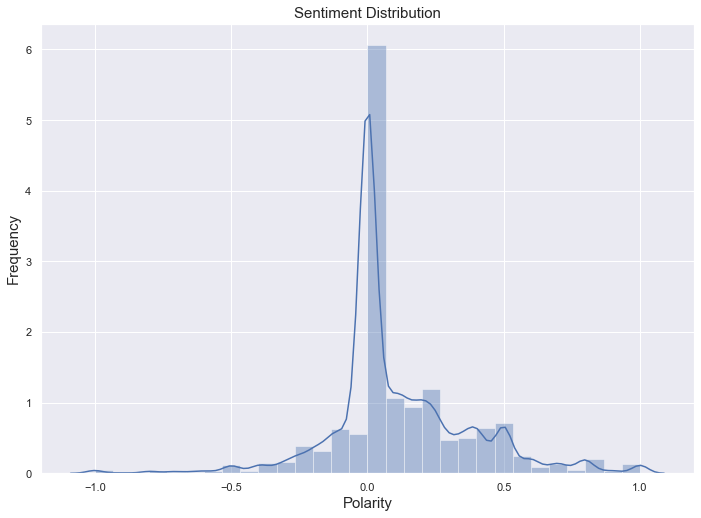

In [38]:
sns.distplot(df_res_pandas['polarity'], bins=30)
plt.title('Sentiment Distribution',size = 15)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show();

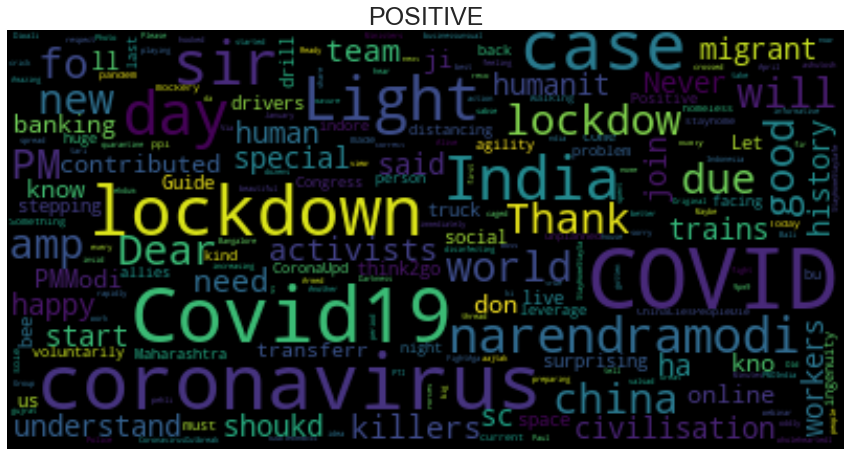

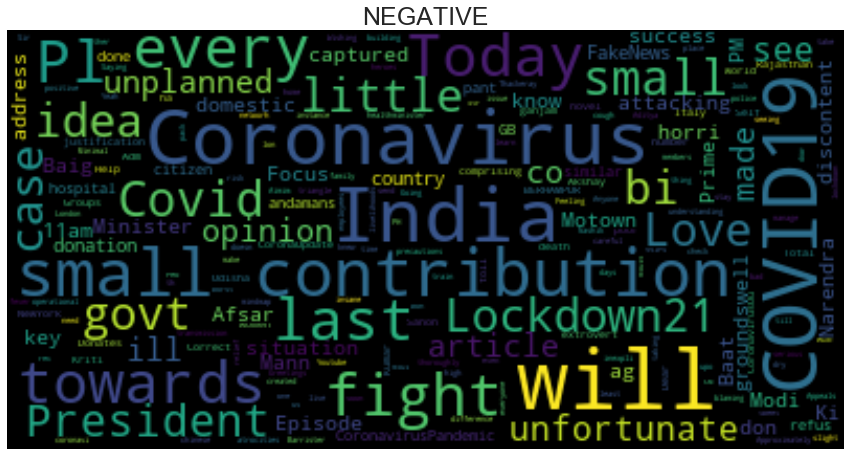

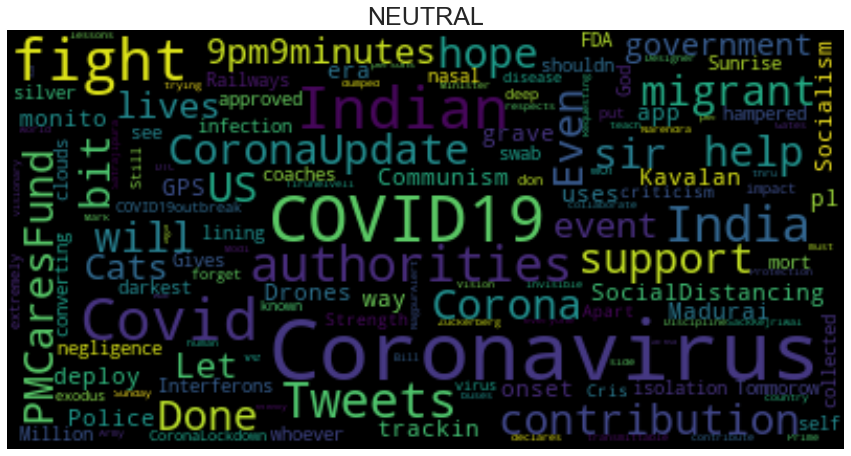

In [40]:
pos = df_res_pandas['text'][df_res_pandas['sentiment'] == 'positive']
show_wordcloud(pos , 'POSITIVE')

neg =df_res_pandas['text'][df_res_pandas['sentiment'] == 'negative']
show_wordcloud(neg , 'NEGATIVE')

neutral = df_res_pandas['text'][df_res_pandas['sentiment'] == 'neutral']
show_wordcloud(neutral , 'NEUTRAL')

In [77]:
words = []
words = [word for i in df_res_pandas.text for word in i.split()]

In [78]:
freq = Counter(words).most_common(30)
freq = pd.DataFrame(freq)
freq.columns = ['word', 'frequency']
freq.head()

word  frequency
0   to       5861
1  the       5556
2   of       4629
3   in       3770
4  and       3012